In [2]:
import numpy as np
from pprint import pprint
from pathlib import Path
from cmap import Colormap, Color
import matplotlib.pyplot as plt
import itertools as iit
from sklearn.linear_model import LogisticRegression
import copy

import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
colors, plotter = styles.init_plt(
    '../plots/notebook/q-sequence',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

### MIP simulation

In [4]:
def create_mip(transitions):
    """
    """
    states = tuple(transitions.keys())
    labels = []
    
    T = {}
    for state, t in transitions.items():
        if len(t) == 0:
            t = [(state, 1.0, [])]
        new_t = []
        for (to_state, tprob, edgeprob) in t:
            if len(edgeprob) == 0:
                edgeprob = 'null'
            if not isinstance(edgeprob, (list, tuple, np.ndarray)):
                edgeprob = [(edgeprob, 1, 0)]
            labels.extend(set([l for (l, _, _) in edgeprob if l not in labels]))
            # normalize edge probabilities
            z = sum([prob for (l, prob, r) in edgeprob])
            edgeprob = [(l, prob/z, r) for (l, prob, r) in edgeprob]
            new_t.append([to_state, tprob, edgeprob])

        z = sum([tprob for (_, tprob, _) in new_t])
        new_t = [(to_state, tprob/z, edgeprob) for (to_state, tprob, edgeprob) in new_t]
        T[state] = new_t

    return {
        'states': states,
        'labels': labels,
        'T': T
    }

def _init_rng(rng):
    if rng is None:
        return np.random.default_rng()
    if isinstance(rng, int):
        return np.random.default_rng(rng)
    return rng


def transition_mip(mip, state, rng = None):
    """
    Returns
    -------
    next_state, label, reward :
        The sampled state, transition label and transition reward.
    """

    rng = _init_rng(rng)
    t = mip['T'][state]
    new_state_i = rng.choice(len(t), p=[tprob for (_, tprob, _) in t])
    edges = t[new_state_i][2]
    edge_i = rng.choice(len(edges), p=[prob for (_, prob, _) in edges])
    return t[new_state_i][0], edges[edge_i][0], edges[edge_i][2]


def iterate_mip(mip, n_steps, state = None, rng = None):
    rng = _init_rng(rng)
    state = state if state is not None else rng.choice(mip['states'])
    states, labels, rewards = [state], [], []
    for i in range(n_steps):
        state, label, reward = transition_mip(mip, state, rng)
        states.append(state)
        labels.append(label)
        rewards.append(reward)
    return states, labels, rewards


def seq_to_onehot(labelseq, labels):
    """
    Parameters
    ----------
    labelseq : list
        A sequence of observations.
    labels : list
        A list of possible labels in order of one-hot index.
    
    Returns
    -------
    np.ndarray
        A one-hot encoding of the label sequence.
    """
    onehot = np.zeros((len(labelseq), len(labels)))
    for i, label in enumerate(labelseq):
        onehot[i, labels.index(label)] = 1
    return onehot

def seq_to_ints(labelseq, labels):
    """
    Parameters
    ----------
    labelseq : list
        A sequence of observations.
    labels : list
        A list of possible labels in order of one-hot index.
    
    Returns
    -------
    np.ndarray
        A one-hot encoding of the label sequence.
    """
    return np.array([labels.index(l) for l in labelseq])

t20 = lambda x: getc(f"seaborn:tab20{x}")

##### examples / testing

In [4]:
mip = create_mip({
    'L': [('R', 1, 'x_lr')],
    'R': [('L', 1, [('x_rl', 1, 1)]),
          ('R', 1, [])],
})

In [92]:
states, labels, rewards = iterate_mip(mip, 10, "L")

In [93]:
print(states)
print(labels)
print(rewards)

['L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R']
['x_lr', 'null', 'x_rl', 'x_lr', 'x_rl', 'x_lr', 'x_rl', 'x_lr', 'x_rl', 'x_lr']
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [94]:
mip = create_mip({
    'L-': [('+', 1, 'a'), ('L-', 1, 'b')],
    'R-': [('+', 1, 'b'), ('R-', 1, 'a')],
    '+': [('iti', 1, [('reset', 1, 1)])],
    'iti': [('iti', 2, 'iti'), ('L-', 1, 'L0'), ('R-', 1, 'R0')],
})
pprint(mip)

{'T': {'+': [('iti', 1.0, [('reset', 1.0, 1)])],
       'L-': [('+', 0.5, [('a', 1.0, 0)]), ('L-', 0.5, [('b', 1.0, 0)])],
       'R-': [('+', 0.5, [('b', 1.0, 0)]), ('R-', 0.5, [('a', 1.0, 0)])],
       'iti': [('iti', 0.5, [('iti', 1.0, 0)]),
               ('L-', 0.25, [('L0', 1.0, 0)]),
               ('R-', 0.25, [('R0', 1.0, 0)])]},
 'labels': ['a', 'b', 'reset', 'iti', 'L0', 'R0'],
 'states': ('L-', 'R-', '+', 'iti')}


In [95]:
states, labels, rewards = iterate_mip(mip, 10, "iti", rng = 1)

In [96]:
for s, l, r in zip(states[1:], labels, rewards):
    print(f"--({l: >7},  {r} )->  {s: <5}")


--(     L0,  0 )->  L-   
--(      a,  0 )->  +    
--(  reset,  1 )->  iti  
--(     R0,  0 )->  R-   
--(      a,  0 )->  R-   
--(      a,  0 )->  R-   
--(      b,  0 )->  +    
--(  reset,  1 )->  iti  
--(    iti,  0 )->  iti  
--(    iti,  0 )->  iti  


In [97]:
seq_to_onehot(labels, mip['labels'])

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

### Encoding of stantes through untrained RNN

In [5]:
from dynrn.basic_rnns import *

In [6]:
def sort_examples(states, labels, rewards):
    """
    Sorts examples by length and returns the sorted examples.

    Parameters:
    - states (list): A list of lists of states, one list of states for each
    session.
    - labels (list): A list of lists of labels, one list of labels for each
    session.
    - rewards (list): A list of lists of rewards, one list of rewards for each
    session. 

    Returns:
    - dict: A dictionary containing the sorted examples with the following keys:
        - 'states': The sorted states.
        - 'labels': The sorted labels.
        - 'rewards': The sorted rewards.
    - dict: A dictionary containing the stacked examples with the following
      keys:
        - 'rewards': The stacked rewards.
        - 'states': The stacked states converted to one-hot encoding.
        - 'labels': The stacked labels converted to one-hot encoding.
    """
    sorted_examples = {
        'states': states,
        'labels': labels,
        'rewards': rewards,
    }
    stacked_examples = {
        'rewards': np.stack(rewards),
        'states': np.stack([seq_to_onehot(s, mip['states']) for s in states]),
        'labels': np.stack([seq_to_onehot(l, mip['labels']) for l in labels]),
    }
    return sorted_examples, stacked_examples

def mip_examples(mip, n_sessions, session_length, rng = None, init_state = None):
    rng = _init_rng(rng)
    examples = [iterate_mip(mip, session_length, init_state, rng) for _ in range(n_sessions)]
    return sort_examples(*zip(*examples))


tpad1d = lambda y, n: np.pad(y[:, None], ((0, 0), (0, n)), constant_values=0).reshape(
    [(n + 1) * y.size]
)
tpad = lambda x, n, axis=0: np.apply_along_axis(lambda y: tpad1d(y, n), axis, x)

def batchsplit(X, y, pct=0.8):
    trn, val = np.split(np.random.permutation(X.shape[0]), [int(pct * X.shape[0])])
    return np.concatenate(X[trn]), np.concatenate(y[trn]), np.concatenate(X[val]), np.concatenate(y[val])


In [97]:
mip = create_mip({
    'L-': [('+', 1, 'a'), ('L-', 3, 'b')],
    'R-': [('+', 1, 'b'), ('R-', 3, 'a')],
    '+': [('iti', 1, [('reset', 1, 1)])],
    'iti': [('iti', 6, 'iti'), ('L-', 1, 'L0'), ('R-', 1, 'R0')],
})
n_sessions = 3
sess_len = 500
examples, ex_onehots = mip_examples(mip, n_sessions, sess_len, rng = 0)
t20 = lambda x: getc(f"seaborn:tab20{x}")
scolors = None
lcolors = {
    'iti': getc('k'), 'reset': getc('grey'), 'a': t20('b:17'), 'b': t20('b:19'), 'L0': t20('c:0'), 'R0': t20('c:2')
}

Invalid color string: 'seaborn:tab20b:17'
Invalid color string: 'seaborn:tab20b:19'
Invalid color string: 'seaborn:tab20c:0'
Invalid color string: 'seaborn:tab20c:2'


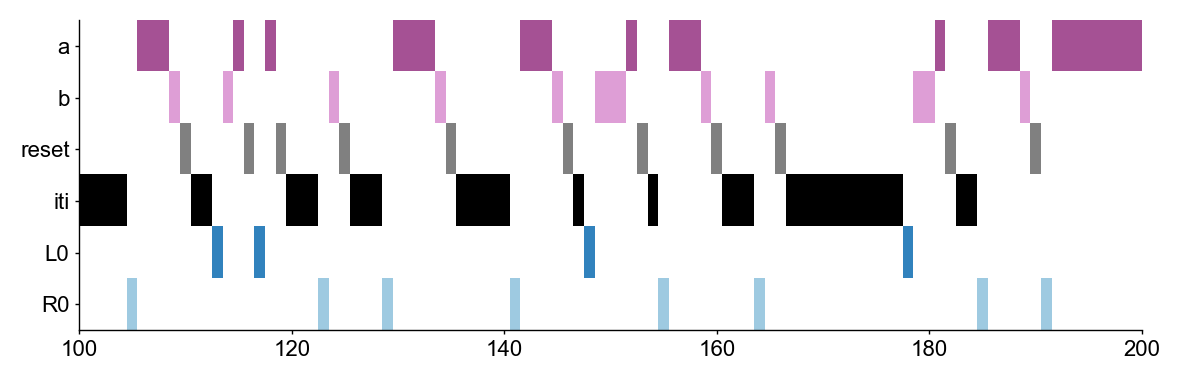

In [51]:
session = 1
c = np.stack([lcolors[l] for l in examples['labels'][session]])[None]
c = (c * ex_onehots['labels'][session].T[..., None])

fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(c, aspect = 'auto', interpolation='nearest')
ax.set_yticks(range(len(mip['labels'])))
ax.set_yticklabels(mip['labels'])
ax.set_xlim(100, 200)

plotter.finalize(fig, None)

(100, 4)

In [116]:

rate = 0
x = th.tensor(tpad(ex_onehots["labels"], rate, axis = 1), dtype=th.float32)
times = np.arange(0, x.shape[1] / (rate + 1), 1 / (rate + 1))
rnn = BasicRNN(x.shape[-1], 80, 20, alpha=0.7, act=nn.ReLU(), w_scale = 1.8)
outputs, hiddens = rnn.seq_forward(x, rnn.init_hidden(x.shape[0]))
# opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
# losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 2000)

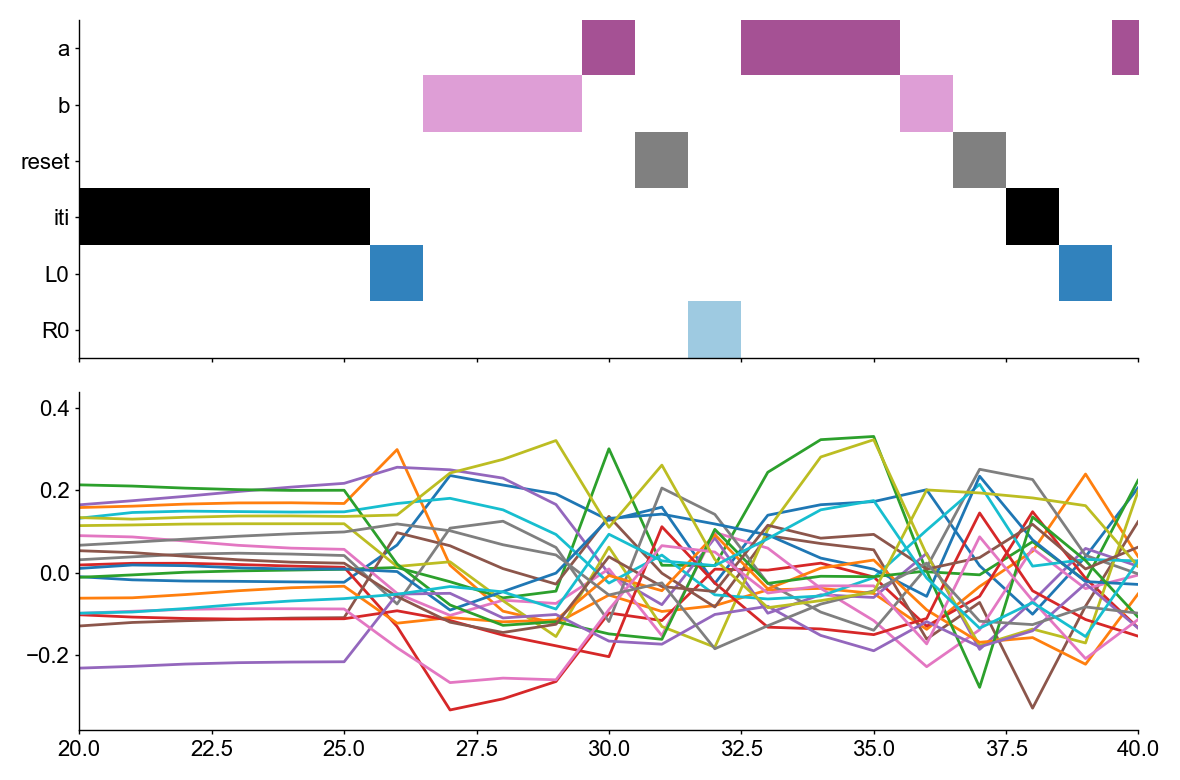

In [117]:
session = 1
c = np.stack([lcolors[l] for l in examples['labels'][session]])[None]
c = (c * ex_onehots['labels'][session].T[..., None])

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex = True)
ax[0].imshow(c, aspect = 'auto')
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])

ax[1].plot(times, outputs[session].detach().numpy())

ax[0].set_xlim(20, 40)

plotter.finalize(fig, None)

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
coords = pca.fit_transform(outputs.detach().numpy().reshape(-1, outputs.shape[-1])).reshape(outputs.shape[0], outputs.shape[1], 3)

(500, 4) (3, 500, 3)


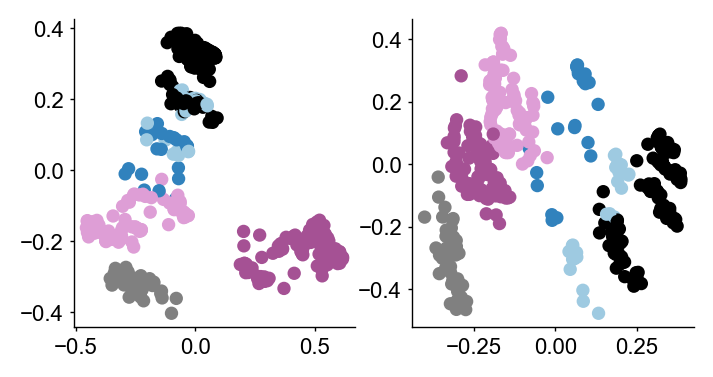

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
session = 1
c = np.stack([[lcolors[l] for l in examples['labels'][i]] for i in range(x.shape[0])])[session]
c = np.repeat(c, rate + 1, axis = 0)
print(c.shape, coords.shape)
ax[0].scatter(*coords[session].T[[0, 1]], c = c)
ax[1].scatter(*coords[session].T[[1, 2]], c = c)

In [122]:
# shape: (session, stimulus, step_within_stimulus, pc)
stepped_coords = coords.reshape(n_sessions, sess_len, rate+1, -1)
stepped_outs = outputs.detach().numpy().reshape(n_sessions, sess_len, rate+1, -1)

In [124]:


Xt, yt, Xv, yv = batchsplit(
    stepped_outs[:, :, 0],
    np.array([seq_to_ints(l, mip["labels"]) for l in examples["labels"]]),
)
LogisticRegression().fit(Xt, yt).score(Xv, yv)

1.0

In [94]:
Xt, yt, Xv, yv = batchsplit(
    ex_onehots["labels"],
    np.array([seq_to_ints(l, mip["labels"]) for l in examples["labels"]]),
)
LogisticRegression().fit(Xt, yt).score(Xv, yv)

((3, 500, 6), torch.Size([3, 1000, 20]))

In [167]:
nhs = np.arange(3, 100, 5)
nys = np.arange(2, 20, 1)
rate = 5
x = th.tensor(tpad(ex_onehots["labels"], rate, axis = 1), dtype=th.float32)
scores = np.zeros((rate + 1, len(nhs), len(nys)))
for (i, nh), (j, ny) in tqdm.tqdm(iit.product(enumerate(nhs), enumerate(nys)), total = len(nhs) * len(nys)):
    rnn = BasicRNN(x.shape[-1], nh, ny, alpha=0.3, act=nn.ReLU(), w_scale = 1.8)
    outputs, hiddens = rnn.seq_forward(x, rnn.init_hidden(x.shape[0]))
    stepped_outs = outputs.detach().numpy().reshape(n_sessions, sess_len, rate+1, -1)
    for k in range(rate + 1):
        Xt, yt, Xv, yv = batchsplit(
            stepped_outs[:, :, k],
            np.array([seq_to_ints(l, mip["labels"]) for l in examples["labels"]]),
        )
        try:
            scores[k, i, j] = LogisticRegression(max_iter = 2000).fit(Xt, yt).score(Xv, yv)
        except ValueError:
            scores[:, i, j] = 0
            break

 33%|███▎      | 118/360 [00:20<00:40,  5.95it/s]/Users/kaifox/bin/miniconda3/envs/loop/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 360/360 [01:03<00:00,  5.71it/s]


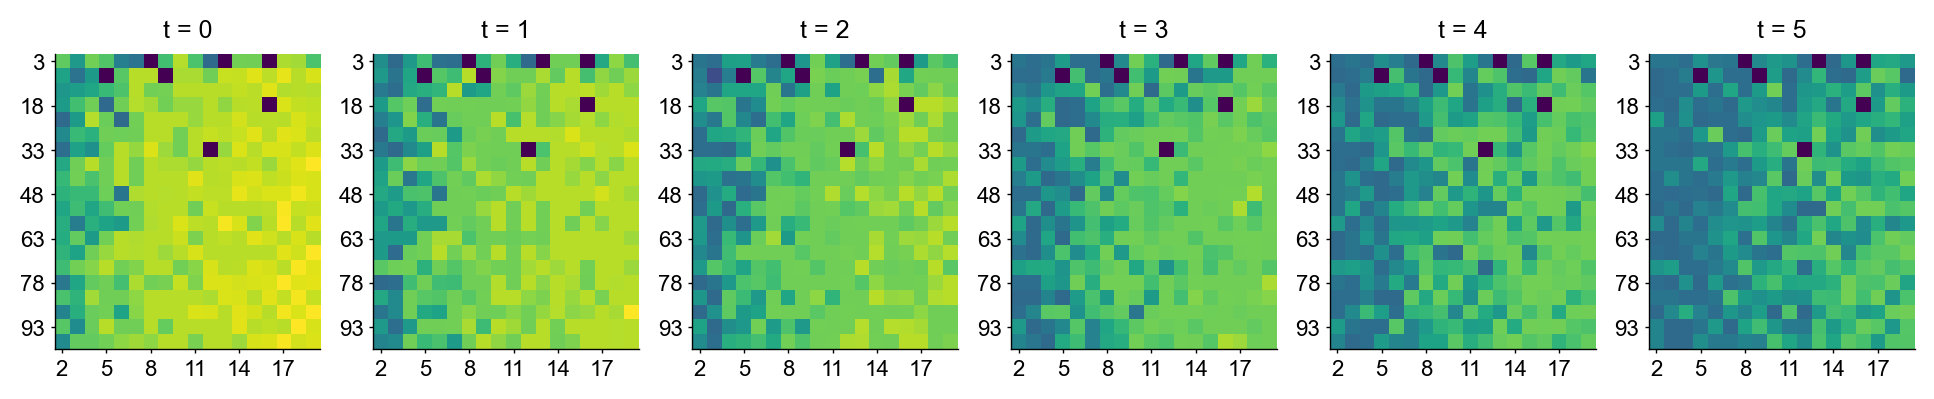

In [168]:
fig, ax = plt.subplots(1, rate + 1, figsize = (2 * rate + 2, 2))
for k in range(rate + 1):
    _ = ax[k].imshow(scores[k], cmap = 'viridis', aspect = 'equal', vmin = 0, vmax = 1)
    ax[k].set_xticks(np.arange(len(nys))[::3])
    ax[k].set_xticklabels(nys[::3])
    ax[k].set_yticks(np.arange(len(nhs))[::3])
    ax[k].set_yticklabels(nhs[::3])
    ax[k].set_title(f"t = {k}")


### parameterized Q learning on simple MDP

In [7]:
def compute_mdp(mip):
    conditioned_probs = {
        s: np.zeros([len(mip['states']), len(mip['labels'])]) for s in mip['states']
    }
    rewards = {
        s: np.zeros([len(mip['states']), len(mip['labels'])]) for s in mip['states']
    }
    valid_labels = {}
    for s in mip['states']:
        for t in mip['T'][s]:
            for edge in t[2]:
                i_s, i_l = mip['states'].index(t[0]), mip['labels'].index(edge[0])
                conditioned_probs[s][i_s, i_l] = edge[1] * t[1]
                rewards[s][i_s, i_l] = edge[2]
        colsums = conditioned_probs[s].sum(axis = 0, keepdims=True)
        valid_labels[s] = np.where(colsums[0] > 0)[0]
        conditioned_probs[s][:, valid_labels[s]] /= colsums[:, valid_labels[s]]
    
    return {
        'states': mip['states'],
        'labels': mip['labels'],
        'T': mip['T'],
        'Tcond': conditioned_probs,
        'actions': valid_labels,
        'rewards': rewards,
    }

def simulate_q_conditioned_mip(mdp, q_policy, n_steps, state=None, rng = None, transition_eps = 0):
    """
    Simulates a Markov Decision Process (MDP) using a Q-policy for a specified
    number of steps. 
    
    Parameters
    ----------
        mdp : dict
            The Markov Decision Process object.
        q_policy : function
            A function that takes a state as input and returns the values of
            each action.
        n_steps : int
            The number of steps to simulate.
        state :
            The initial state to start the simulation from. If not provided, a
            random state will be chosen.
        rng : np.random.Generator, int, None
            A random number generator or seed for reproducibility.
        transition_eps : float
            A small value to add to the transition probabilities to avoid
            degeneracy.
    
    Returns:
        states : list
            A list of states visited during the simulation.
        labels : list
            A list of labels associated with each state transition.
        rewards : list
            A list of rewards received at each step.
    """
    state = state if state is not None else np.random.choice(mdp['states'])
    states, labels, rewards = [state], [], []
    nstate = len(mdp['states'])
    rng = _init_rng(rng)

    for i in range(n_steps):

        q = q_policy(state).detach().numpy() # function state -> values of each action
        a = mdp['actions'][state][np.argmax(q[mdp['actions'][state]])]

        p = mdp['Tcond'][state][:, a] + transition_eps
        next_state_i = rng.choice(nstate, p = p / p.sum())

        r = mdp['rewards'][state][next_state_i, a]
        state = mdp['states'][next_state_i]

        
        states.append(state)
        labels.append(mdp['labels'][a])
        rewards.append(r)
    
    return states, labels, rewards

def simulate_q_conditioned_mips(mdp, q_policy, n_sessions, n_steps, state=None, rng = None, transition_eps = 0):
    states, labels, rewards = [], [], []
    for _ in range(n_sessions):
        s, l, r = simulate_q_conditioned_mip(mdp, q_policy, n_steps, state, rng, transition_eps)
        states.append(s)
        labels.append(l)
        rewards.append(r)
    return states, labels, rewards


In [8]:
mip = create_mip({
    'L-': [('+', 1, 'a'), ('L-', 9, 'b')],
    'R-': [('+', 1, 'b'), ('R-', 9, 'a')],
    '+': [('iti', 1, [('reset', 1, 1)])],
    'iti': [('iti', 12, 'iti'), ('L-', 1, 'L0'), ('R-', 1, 'R0')],
})

scolors = {
    'iti': getc('k'), '+': t20('c:9'), 'L-': t20('b:0'), 'R-': t20('b:2')
}
lcolors = {
    'iti': getc('k'), 'reset': getc('grey'), 'a': t20('b:17'), 'b': t20('b:19'), 'L0': t20('c:0'), 'R0': t20('c:2')
}

pprint(mip)

{'T': {'+': [('iti', 1.0, [('reset', 1.0, 1)])],
       'L-': [('+', 0.1, [('a', 1.0, 0)]), ('L-', 0.9, [('b', 1.0, 0)])],
       'R-': [('+', 0.1, [('b', 1.0, 0)]), ('R-', 0.9, [('a', 1.0, 0)])],
       'iti': [('iti', 0.8571428571428571, [('iti', 1.0, 0)]),
               ('L-', 0.07142857142857142, [('L0', 1.0, 0)]),
               ('R-', 0.07142857142857142, [('R0', 1.0, 0)])]},
 'labels': ['a', 'b', 'reset', 'iti', 'L0', 'R0'],
 'states': ('L-', 'R-', '+', 'iti')}


In [11]:
c = Color('black')
c.rgba

RGBA(r=0.0, g=0.0, b=0.0, a=1)

In [14]:
print({k: c.hex for k, c in scolors.items()})
print({k: c.hex for k, c in lcolors.items()})

{'iti': '#000000', '+': '#74C476', 'L-': '#393B79', 'R-': '#6B6ECF'}
{'iti': '#000000', 'reset': '#808080', 'a': '#A55194', 'b': '#DE9ED6', 'L0': '#3182BD', 'R0': '#9ECAE1'}


In [449]:
naction = len(mip['labels'])
rng = np.random.default_rng(0)
q_policy = lambda s: th.tensor(rng.normal(size=naction), dtype=th.float32)
mdp = compute_mdp(mip)
states, labels, rewards = simulate_q_conditioned_mip(mdp, q_policy, 5, state = "iti", rng = 0)

In [450]:
print(states[0])
for i in range(len(labels)):
    print(f"--({labels[i]: >7},  {rewards[i]}) ->  {states[i+1]: <5}")

iti
--(     R0,  0.0) ->  R-   
--(      a,  0.0) ->  R-   
--(      b,  0.0) ->  +    
--(  reset,  1.0) ->  iti  
--(     R0,  0.0) ->  R-   


In [458]:
# conditioned mip transitions
states, labels, rewards = simulate_q_conditioned_mips(mdp, q_policy, 50, 200, state = "iti", rng = 0)
examples, ex_onehots = sort_examples(states, labels, rewards)

In [8]:
# raw mip transitions
n_sessions = 50
sess_len = 200
examples, ex_onehots = mip_examples(mip, 50, 200, rng = 0, init_state = "iti")

(20, 100, 6)

##### differential (tabular / lienar) TD learning from states

$$\begin{align}
\mathcal{L} &= \left | \left | y_{t+1} - \hat{V}(s_t)  \right | \right | ^2,\\
\text{with}\ y_{y+1} &= r_{t\rightarrow t+1} + \gamma\hat{V}(s_{t+1})
\end{align}$$

In [452]:
nstate = len(mdp['states'])
vhat_nn = nn.Linear(nstate, 1, bias=False)
vhat_nn.weight.data.fill_(0)
opt = optim.Adam(vhat_nn.parameters(), lr=5e-3)
x = th.tensor(ex_onehots["states"], dtype=th.float32)
r = th.tensor(ex_onehots["rewards"], dtype=th.float32)
gamma = 0.99

In [453]:
# single GD step
n_steps = 300
rpe_hist = []
losses = []
vhat_hists = []

for i in tqdm.trange(n_steps):
    opt.zero_grad()
    vhats = vhat_nn(x).squeeze()
    y = r + gamma * vhats[:, 1:]
    rpe = y - vhats[:, :-1]
    loss = rpe.pow(2).mean()
    loss.backward()
    opt.step()

    rpe_hist.append(rpe.detach().numpy())
    losses.append(loss.detach().numpy())
    vhat_hists.append(vhats.detach().numpy())

100%|██████████| 300/300 [00:00<00:00, 2491.90it/s]


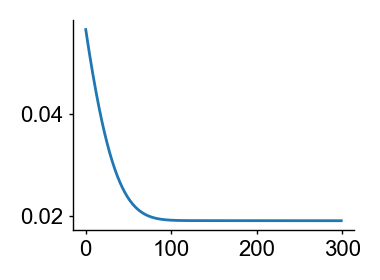

In [454]:
fig, ax = plt.subplots(figsize=(2, 1.5))
ax.plot(losses)
plotter.finalize(fig, None)

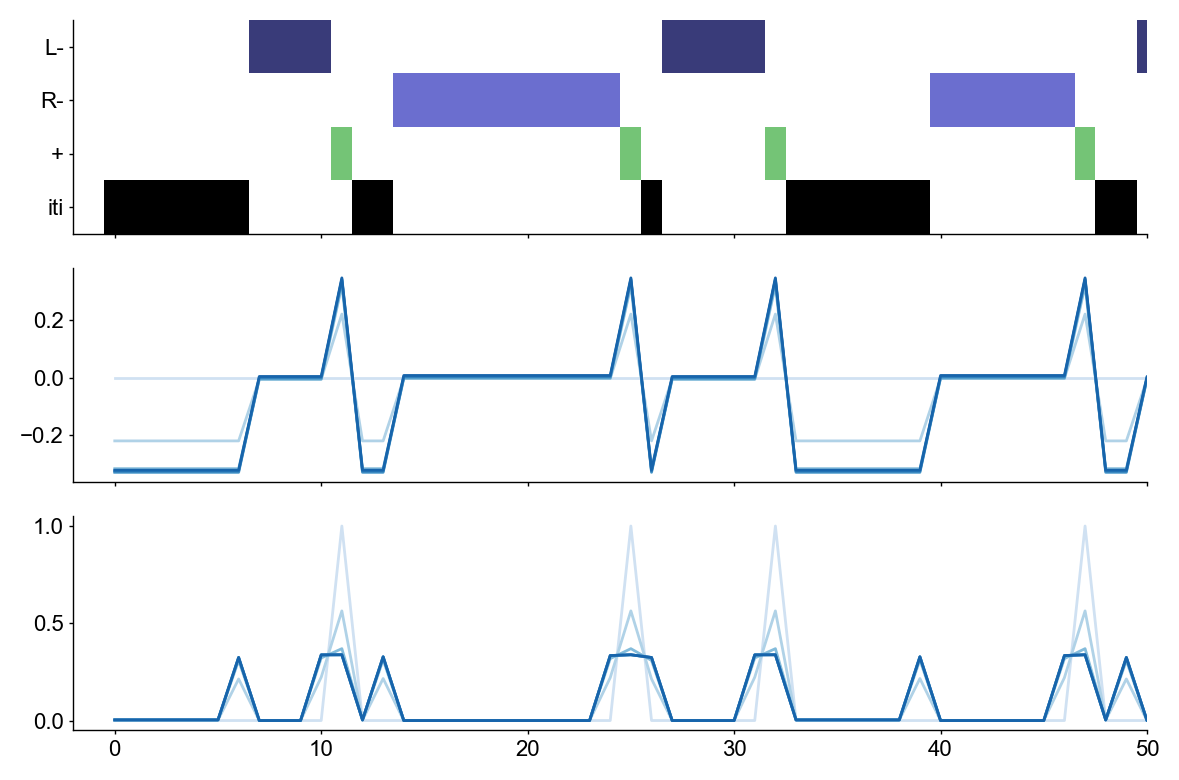

In [457]:
session = 0
steps = np.arange(0, 300, 50)
step_colors = Colormap('blues')(np.linspace(0.2, 0.8, len(steps)))

c = np.stack([scolors[s] for s in examples['states'][session]])[None]
c = (c * ex_onehots['states'][session].T[..., None])

fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex = True)
ax[0].imshow(c, aspect = 'auto')
ax[0].set_yticks(range(len(mip['states'])))
ax[0].set_yticklabels(mip['states'])

for i, step in enumerate(steps):
    ax[1].plot(vhat_hists[step][session], color = step_colors[i])
    ax[2].plot(rpe_hist[step][session], color = step_colors[i])

ax[0].set_xlim(-2, 50)



plotter.finalize(fig, None)

((200,), torch.Size([200]))

### quadratic paramterized $Q$

$\mathcal{L}_V$ as above to learn $\hat{V}$. Then

$$\begin{align}
\mathcal{L}_Q &= \left | \left | y_{t+1} - \hat{Q}(s_t, a_t)  \right | \right | ^2,\\
\text{with}\ y_{y+1} &= r_{t\rightarrow t+1} + \gamma\max_a\hat{Q}(s_{t+1}, a) \\
\text{and}\ \hat{Q}(s, a) &= \hat{V}(s) + \frac{1}{\sigma^2}\left|\left|\mu(s) - a\right|\right|^2
\end{align}$$

or alternatively learn $\hat V$ directly from $\mathcal{L}_Q$ also.

In [506]:
list(vhat_nn.parameters())

[Parameter containing:
 tensor([[0., 0., 0., 0.]], requires_grad=True)]

In [571]:
nstate = len(mdp['states'])
nlabel = len(mdp['labels'])
vhat_nn = nn.Linear(nstate, 1, bias=False)
mu_nn = nn.Linear(nstate, nlabel, bias=False)

vhat_nn.weight.data.fill_(0)
mu_nn.weight.data.fill_(0)
# opt = optim.Adam(list(vhat_nn.parameters()) + list(mu_nn.parameters()), lr=8e-3)
vhat_opt = optim.Adam(vhat_nn.parameters(), lr=8e-3)
mu_opt = optim.Adam(mu_nn.parameters(), lr=8e-3)

x = th.tensor(ex_onehots["states"], dtype=th.float32)
a = th.tensor(ex_onehots["labels"], dtype=th.float32)
r = th.tensor(ex_onehots["rewards"], dtype=th.float32)
gamma = 0.99
sigmasq = 500

In [572]:
# single GD step
n_steps = 300
rpe_hist = []
losses = []
mu_losses = []
vhat_hists = []
mu_hist = []

for i in tqdm.trange(n_steps):
    vhat_opt.zero_grad()
    mu_opt.zero_grad()
    vhats = vhat_nn(x).squeeze() # value of s_t and s_{t+1}
    mus = mu_nn(x[:, :-1]).squeeze() # action selected from s_t
    action_surprise = (a - mus).pow(2).sum(axis = -1) # |a_t - mu(s_t)|^2
    y = r + gamma * vhats[:, 1:] # TD target
    rpe = y - vhats[:, :-1] # TD error
    action_adj_rpe = rpe + action_surprise / sigmasq # parameterized Q error

    loss = rpe.pow(2).mean()
    loss.backward(retain_graph=True)
    vhat_opt.step()
    mu_loss = action_adj_rpe.pow(2).mean()
    mu_loss.backward()
    mu_opt.step()

    rpe_hist.append(rpe.detach().numpy())
    losses.append(loss.detach().numpy())
    mu_losses.append(mu_loss.detach().numpy())
    vhat_hists.append(vhats.detach().numpy())
    mu_hist.append(mus.detach().numpy())

100%|██████████| 300/300 [00:00<00:00, 785.37it/s]


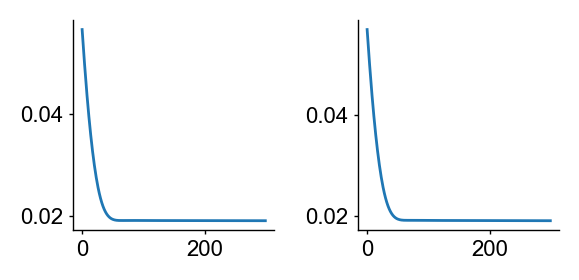

In [573]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
ax[0].plot(losses)
ax[1].plot(mu_losses)
plotter.finalize(fig, None)

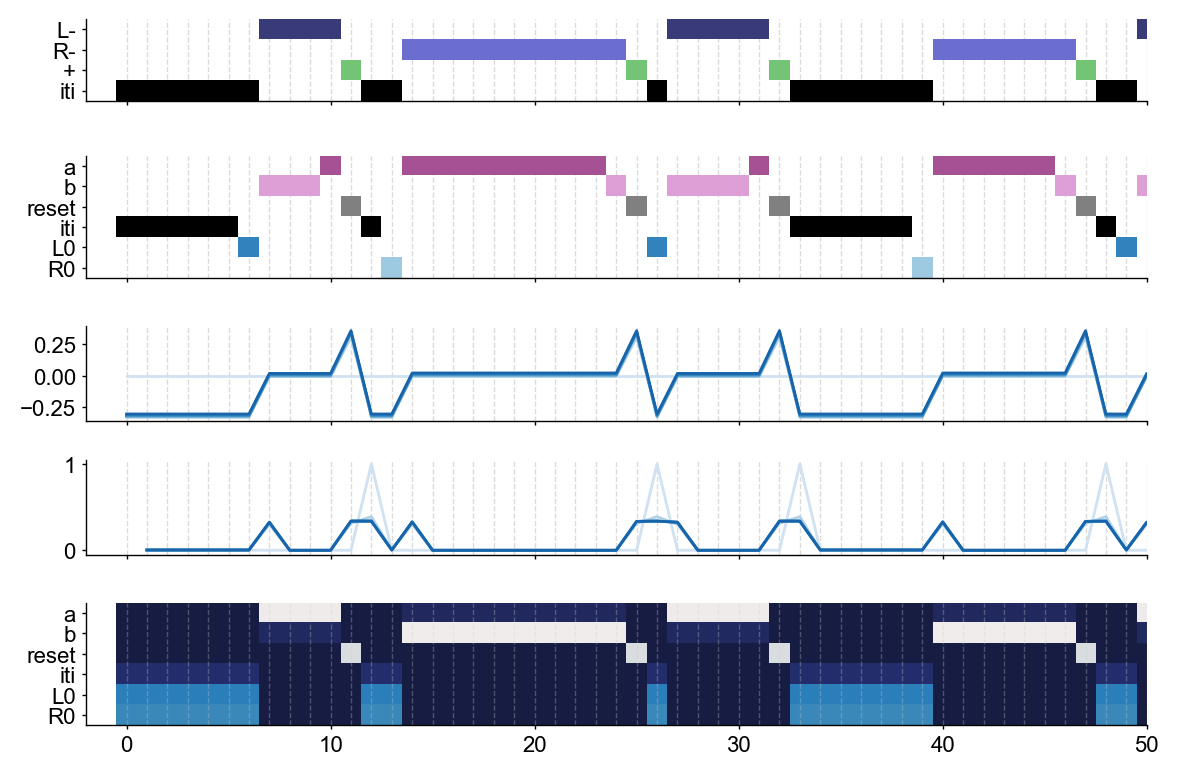

In [574]:
session = 0
steps = np.arange(0, 300, 50)
step_colors = Colormap("blues")(np.linspace(0.2, 0.8, len(steps)))

cs = np.stack([scolors[s] for s in examples["states"][session]])[None]
cs = cs * ex_onehots["states"][session].T[..., None]

cl = np.stack([lcolors[l] for l in examples["labels"][session]])[None]
cl = cl * ex_onehots["labels"][session].T[..., None]

fig, ax = plt.subplots(
    5, 1, figsize=(6, 4), sharex=True, height_ratios=[1, 1.5, 1, 1, 1.5]
)
ax[0].imshow(cs, aspect="equal")
ax[0].set_yticks(range(len(mip["states"])))
ax[0].set_yticklabels(mip["states"])

ax[1].imshow(cl, aspect="equal")
ax[1].set_yticks(range(len(mip["labels"])))
ax[1].set_yticklabels(mip["labels"])

for i, step in enumerate(steps):
    ax[2].plot(vhat_hists[step][session], color=step_colors[i])
    ax[3].plot(np.arange(1, cs.shape[1]), rpe_hist[step][session], color=step_colors[i])

ax[4].imshow(
    mu_hist[steps[-1]][session].T,
    aspect="equal",
    interpolation="nearest",
    cmap=Colormap("cmocean:balance_blue").to_mpl(),
)
ax[4].set_yticks(range(len(mip["labels"])))
ax[4].set_yticklabels(mip["labels"])

ax[0].set_xlim(-2, 50)

for i in range(x.shape[1]):
    for a in ax[:-1]:
        a.axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.7, zorder = -1)
    ax[4].axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.3)

plotter.finalize(fig, None)

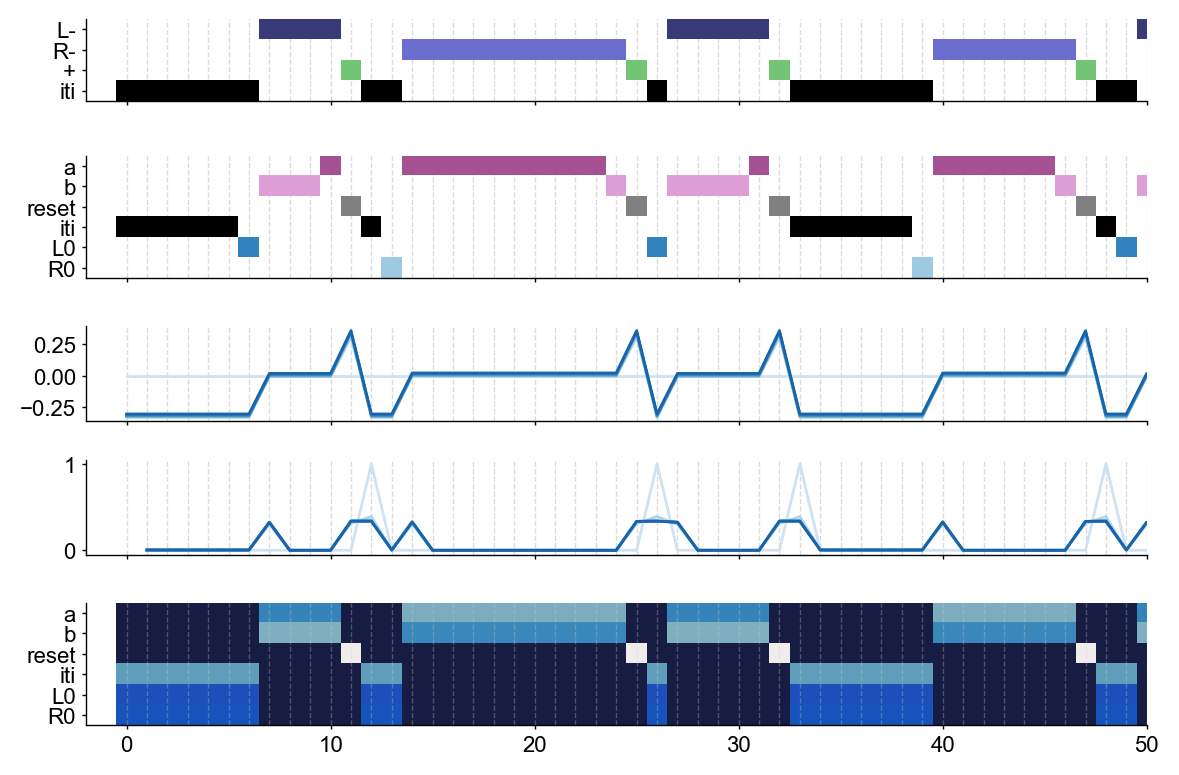

In [570]:
session = 0
steps = np.arange(0, 300, 50)
step_colors = Colormap("blues")(np.linspace(0.2, 0.8, len(steps)))

cs = np.stack([scolors[s] for s in examples["states"][session]])[None]
cs = cs * ex_onehots["states"][session].T[..., None]

cl = np.stack([lcolors[l] for l in examples["labels"][session]])[None]
cl = cl * ex_onehots["labels"][session].T[..., None]

fig, ax = plt.subplots(
    5, 1, figsize=(6, 4), sharex=True, height_ratios=[1, 1.5, 1, 1, 1.5]
)
ax[0].imshow(cs, aspect="equal")
ax[0].set_yticks(range(len(mip["states"])))
ax[0].set_yticklabels(mip["states"])

ax[1].imshow(cl, aspect="equal")
ax[1].set_yticks(range(len(mip["labels"])))
ax[1].set_yticklabels(mip["labels"])

for i, step in enumerate(steps):
    ax[2].plot(vhat_hists[step][session], color=step_colors[i])
    ax[3].plot(np.arange(1, cs.shape[1]), rpe_hist[step][session], color=step_colors[i])

ax[4].imshow(
    mu_hist[steps[-1]][session].T,
    aspect="equal",
    interpolation="nearest",
    cmap=Colormap("cmocean:balance_blue").to_mpl(),
)
ax[4].set_yticks(range(len(mip["labels"])))
ax[4].set_yticklabels(mip["labels"])

ax[0].set_xlim(-2, 50)

for i in range(x.shape[1]):
    for a in ax[:-1]:
        a.axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.7, zorder = -1)
    ax[4].axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.3)

plotter.finalize(fig, None)

In [649]:
class NormalizeLastDim(nn.Module):
    def forward(self, x):
        return x / (th.norm(x, dim=-1, keepdim=True) + 0.1)

In [669]:
nstate = len(mdp['states'])
nlabel = len(mdp['labels'])
vhat_nn = nn.Linear(nstate, 1, bias=False)
mu_nn = nn.Sequential(
    nn.Linear(nstate, nlabel, bias=False),
    # NormalizeLastDim(),
)

vhat_nn.weight.data.fill_(0)
mu_nn[0].weight.data.fill_(0)
# opt = optim.Adam(list(vhat_nn.parameters()) + list(mu_nn.parameters()), lr=8e-3)
vhat_opt = optim.Adam(vhat_nn.parameters(), lr=8e-3)
mu_opt = optim.Adam(mu_nn.parameters(), lr=8e-3)

x = th.tensor(ex_onehots["states"], dtype=th.float32)
a = th.tensor(ex_onehots["labels"], dtype=th.float32)
r = th.tensor(ex_onehots["rewards"], dtype=th.float32)
gamma = 0.99
sigmasq = 5

In [670]:
# single GD step
n_steps = 300
rpe_hist = []
losses = []
mu_losses = []
q_rpe_hist = []
vhat_hists = []
mu_hist = []

for i in tqdm.trange(n_steps):
    vhat_opt.zero_grad()
    mu_opt.zero_grad()
    vhats = vhat_nn(x).squeeze() # value of s_t and s_{t+1}
    mus = mu_nn(x[:, :-1]).squeeze() # action selected from s_t

    y = r + gamma * vhats[:, 1:] # TD target
    rpe = y - vhats[:, :-1] # TD error
    loss = rpe.pow(2).mean()
    loss.backward(retain_graph=True)
    vhat_opt.step()

    mu_minus_a = mu_nn(x[:, 1:])[..., None] - th.eye(nlabel)[None, None]
    q_quad = (mu_minus_a).pow(2).sum(axis = -1) / sigmasq
    q_max = vhats[:, 1:] - q_quad.max(axis = -1).values # max_i Q(s_{t+1}, a_i)
    action_surprise = (a - mus).pow(2).sum(axis = -1) # |a_t - mu(s_t)|^2
    q_t = vhats[:, :-1] - action_surprise / sigmasq
    y = r + gamma * q_max # Q learning target
    q_rpe = y - q_t # Q learning error

    mu_loss = q_rpe.pow(2).mean()
    mu_loss.backward()
    mu_opt.step()

    rpe_hist.append(rpe.detach().numpy())
    q_rpe_hist.append(q_rpe.detach().numpy())
    losses.append(loss.detach().numpy())
    mu_losses.append(mu_loss.detach().numpy())
    vhat_hists.append(vhats.detach().numpy())
    mu_hist.append(mus.detach().numpy())

100%|██████████| 300/300 [00:00<00:00, 334.42it/s]


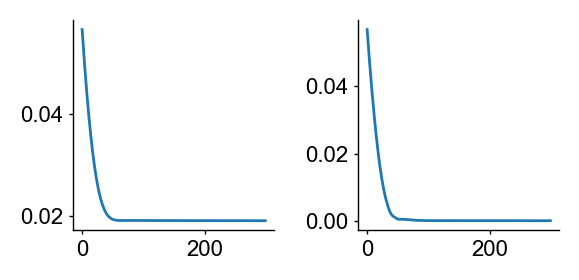

In [671]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
ax[0].plot(losses)
ax[1].plot(mu_losses)
plotter.finalize(fig, None)

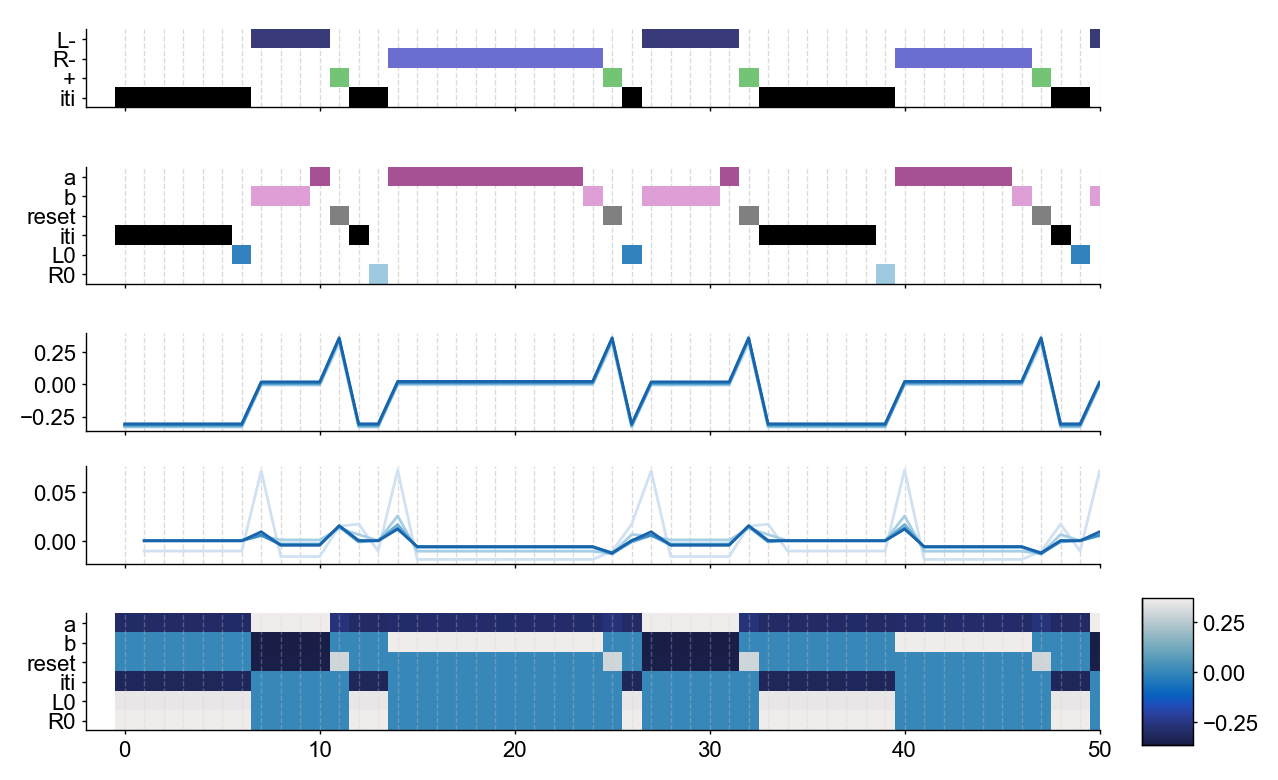

In [681]:
session = 0
steps = np.arange(50, 300, 50)
step_colors = Colormap("blues")(np.linspace(0.2, 0.8, len(steps)))

cs = np.stack([scolors[s] for s in examples["states"][session]])[None]
cs = cs * ex_onehots["states"][session].T[..., None]

cl = np.stack([lcolors[l] for l in examples["labels"][session]])[None]
cl = cl * ex_onehots["labels"][session].T[..., None]

fig, ax = plt.subplots(
    5, 2, figsize=(6.5, 4), sharex='col', height_ratios=[1, 1.5, 1, 1, 1.5], width_ratios=[1, 0.05]
)
cax = ax[:, 1]
ax = ax[:, 0]
ax[0].imshow(cs, aspect="equal")
ax[0].set_yticks(range(len(mip["states"])))
ax[0].set_yticklabels(mip["states"])

ax[1].imshow(cl, aspect="equal")
ax[1].set_yticks(range(len(mip["labels"])))
ax[1].set_yticklabels(mip["labels"])

for i, step in enumerate(steps):
    ax[2].plot(vhat_hists[step][session], color=step_colors[i])
    ax[3].plot(np.arange(1, cs.shape[1]), q_rpe_hist[step][session], color=step_colors[i])

vrng = max(abs(np.array(vhat_hists).max()), abs(np.array(vhat_hists).min()))
_ = ax[4].imshow(
    mu_hist[steps[-1]][session].T,
    vmin = -vrng, vmax = vrng,
    aspect="equal",
    interpolation="nearest",
    cmap=Colormap("cmocean:balance_blue").to_mpl(),
)
fig.colorbar(_, cax = cax[4])
ax[4].set_yticks(range(len(mip["labels"])))
ax[4].set_yticklabels(mip["labels"])

ax[0].set_xlim(-2, 50)

for i in range(x.shape[1]):
    for a_ in ax[:-1]:
        a_.axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.7, zorder = -1)
    ax[4].axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.3)

for a_ in cax[:-1]:
    a_.set_axis_off()

plotter.finalize(fig, None)

### RNN with gating

In [9]:
class InputGatedRNN(NegRNN):

    def __init__(
        self,
        nx,
        nh,
        ny=None,
        alpha=0.1,
        act=nn.Sigmoid(),
        h_bias=0,
        w_scale=1,
        act_ofs=0,
    ):
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)

        self.i2h = nn.Linear(self.nx, self.nh, bias=False)
        self.h2h = nn.Linear(self.nh, self.nh, bias=False)
        self.h2y = nn.Linear(self.nh, self.ny, bias=False)

    def forward(self, x, h, g):
        return super().forward(g * x, h)
    
    def seq_forward(self, x, h, y, y2g):
        ys = []
        hs = []
        gs = []
        for i in range(x.shape[1]):
            g = y2g(y)
            # print(y.shape, h.shape, g.shape, x[:, i].shape)
            y, h = self.forward(x[:, i], h, g)
            ys.append(y)
            hs.append(h)
            gs.append(g)
        return th.stack(ys, dim=1), th.stack(hs, dim=1), th.stack(gs, dim = 1)
    
    def init_output(self, batch_size):
        return th.zeros(batch_size, self.ny)


In [858]:
rate = 0
x = th.tensor(tpad(ex_onehots["labels"], rate, axis = 1), dtype=th.float32)
times = np.arange(0, x.shape[1] / (rate + 1), 1 / (rate + 1))

gate_rng = np.random.default_rng(10)
testgate = lambda y: th.tensor(gate_rng.uniform(size = (n_sessions, 6)) < 0.3, dtype=th.float32)

rnn = InputGatedRNN(x.shape[-1], 80, 20, alpha=0.7, act=nn.ReLU(), w_scale = 1.8)
h0 = rnn.init_hidden(x.shape[0])
y0 = rnn.init_output(x.shape[0])
outputs, hiddens, gates = rnn.seq_forward(x, h0, y0, testgate)

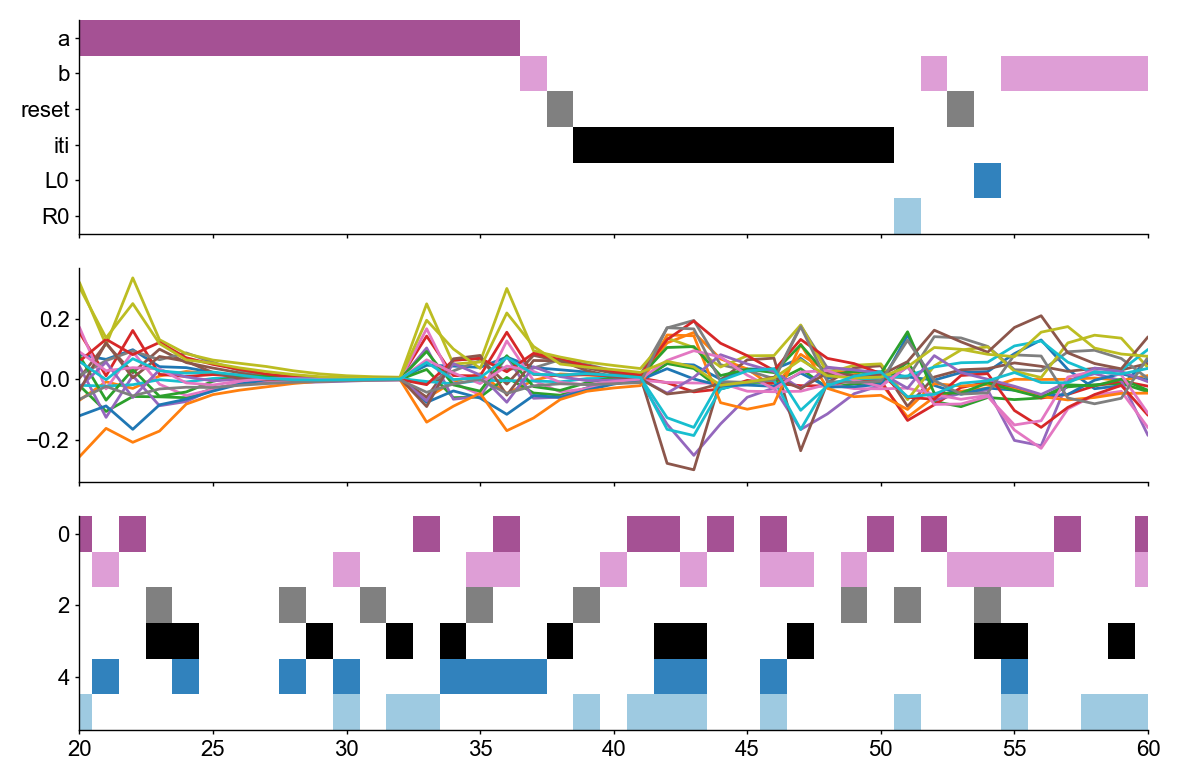

In [841]:
session = 1
c = np.stack([lcolors[l] for l in examples['labels'][session]])[None]
c = (c * ex_onehots['labels'][session].T[..., None])

fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex = True)
ax[0].imshow(c, aspect = 'auto')
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])

ax[1].plot(times, outputs[session].detach().numpy())
g = gates[None, session].T.numpy() * np.stack([lcolors[l] for g, l in zip(gates, mip['labels'])])[:, None]
ax[2].imshow(g, aspect = 'auto', cmap = 'bone')
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])

ax[0].set_xlim(20, 60)

plotter.finalize(fig, None)

In [859]:
gate_rng = np.random.default_rng(10)
random_relu_gate = lambda h: th.tensor(gate_rng.uniform(size = (n_sessions, len(mip['labels']))), dtype=th.float32)

rnn = InputGatedRNN(x.shape[-1], 80, 20, alpha=0.7, act=nn.ReLU(), w_scale = 1.8)
h0 = rnn.init_hidden(x.shape[0]); y0 = rnn.init_output(x.shape[0])
outputs, hiddens, gates = rnn.seq_forward(x, h0, y0, random_relu_gate)

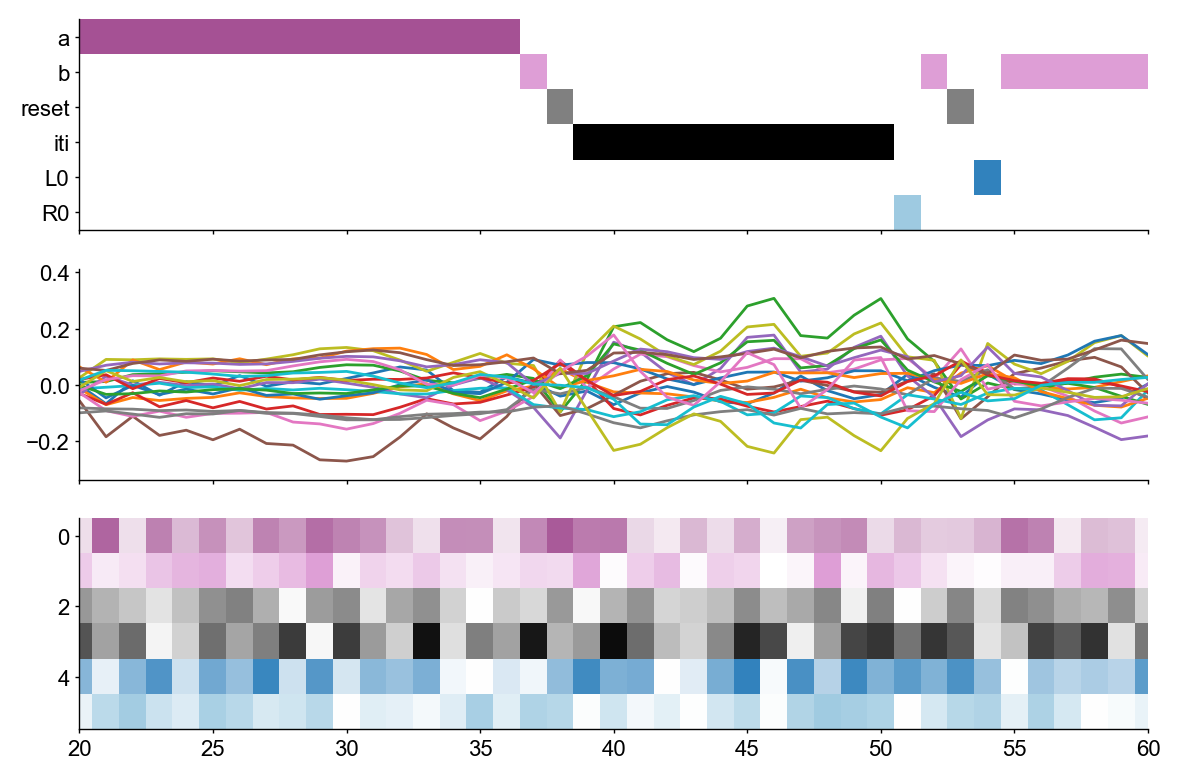

In [860]:
session = 1
cl = np.stack([lcolors[l] for l in examples['labels'][session]])[None]
cl = (cl * ex_onehots['labels'][session].T[..., None])

normed_g = gates[session].numpy() / gates[session].max().numpy()
cg = np.tile(np.stack([lcolors[l] for g, l in zip(gates, mip['labels'])])[:, None], [1, sess_len, 1])
cg[..., 3] = normed_g.T

fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex = True)
ax[0].imshow(cl, aspect = 'auto')
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])

ax[1].plot(times, outputs[session].detach().numpy())

ax[2].imshow(cg, aspect = 'auto', cmap = 'bone')
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])
ax[0].set_yticks(range(len(mip['labels'])))
ax[0].set_yticklabels(mip['labels'])

ax[0].set_xlim(20, 60)

plotter.finalize(fig, None)

In [889]:
nstate = len(mdp['states'])
nlabel = len(mdp['labels'])
rnnout = outputs.shape[-1]
vhat_nn = nn.Linear(rnnout, 1, bias=False)
mu_nn = nn.Sequential(
    nn.Linear(rnnout, nlabel, bias = True),
    nn.Softmax(dim = -1),
)

vhat_nn.weight.data.fill_(0)
mu_nn[0].weight.data.fill_(0)
vhat_opt = optim.Adam(vhat_nn.parameters(), lr=4e-2)
mu_opt = optim.Adam(mu_nn.parameters(), lr=4e-2)

qx = th.concat([outputs, y0[:, None]], dim = 1).detach()
a = gates.detach()
r = th.tensor(ex_onehots["rewards"], dtype=th.float32)
gamma = 0.99
sigmasq = 500

In [890]:
n_steps = 400
rpe_hist = []
losses = []
mu_losses = []
vhat_hists = []
mu_hist = []

for i in tqdm.trange(n_steps):
    vhat_opt.zero_grad()
    mu_opt.zero_grad()
    vhats = vhat_nn(qx).squeeze() # value of s_t and s_{t+1}
    mus = mu_nn(qx[:, :-1]).squeeze() # action selected from s_t
    action_surprise = (a - mus).pow(2).sum(axis = -1) # |a_t - mu(s_t)|^2
    y = r + gamma * vhats[:, 1:] # TD target
    rpe = y - vhats[:, :-1] # TD error
    action_adj_rpe = rpe + action_surprise / sigmasq # parameterized Q error

    loss = rpe.pow(2).mean()
    loss.backward(retain_graph=True)
    vhat_opt.step()
    mu_loss = action_adj_rpe.pow(2).mean()
    mu_loss.backward()
    mu_opt.step()

    rpe_hist.append(rpe.detach().numpy())
    losses.append(loss.detach().numpy())
    mu_losses.append(mu_loss.detach().numpy())
    vhat_hists.append(vhats.detach().numpy())
    mu_hist.append(mus.detach().numpy())

100%|██████████| 400/400 [00:00<00:00, 531.38it/s]


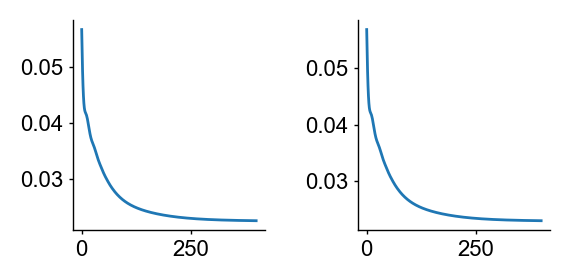

In [892]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
ax[0].plot(losses)
ax[1].plot(mu_losses)
plotter.finalize(fig, None)

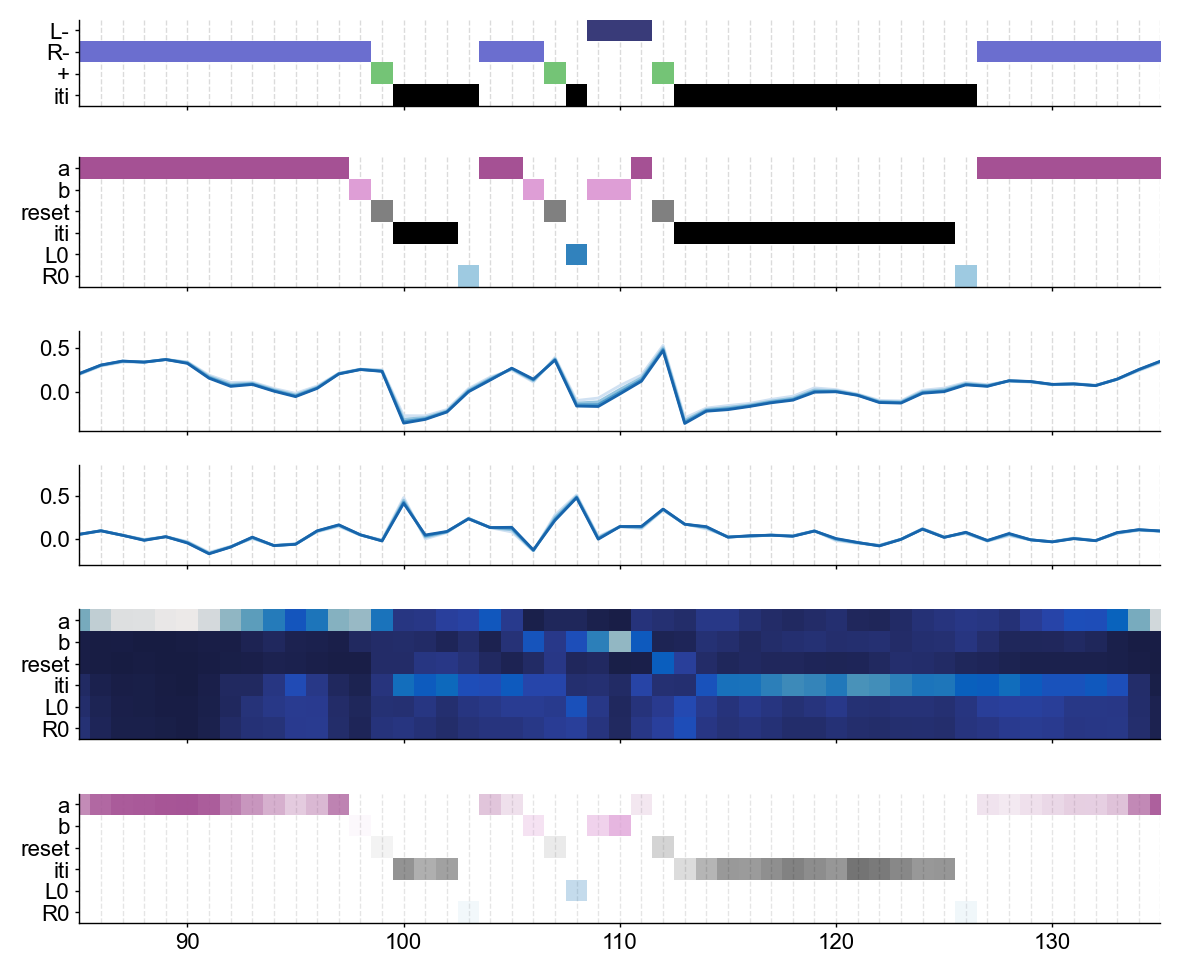

In [893]:
session = 0
steps = np.arange(200, n_steps, 50)
step_colors = Colormap("blues")(np.linspace(0.2, 0.8, len(steps)))

cs = np.stack([scolors[s] for s in examples["states"][session]])[None]
cs = cs * ex_onehots["states"][session].T[..., None]

cl = np.stack([lcolors[l] for l in examples["labels"][session]])[None]
cl = cl * ex_onehots["labels"][session].T[..., None]

# a = nn.functional.softplus(th.tensor(mu_hist[-1], dtype=th.float32)).numpy()
a = mu_hist[-1]
normed_g = a[session] / a[session].max()
cgl = cl.copy()
cgl[..., 3] *= normed_g.T

fig, ax = plt.subplots(
    6, 1, figsize=(6, 5), sharex=True, height_ratios=[1, 1.5, 1, 1, 1.5, 1.5]
)
ax[0].imshow(cs, aspect="equal")
ax[0].set_yticks(range(len(mip["states"])))
ax[0].set_yticklabels(mip["states"])

ax[1].imshow(cl, aspect="equal")
ax[1].set_yticks(range(len(mip["labels"])))
ax[1].set_yticklabels(mip["labels"])

for i, step in enumerate(steps):
    ax[2].plot(vhat_hists[step][session], color=step_colors[i])
    ax[3].plot(np.arange(1, cs.shape[1]), rpe_hist[step][session], color=step_colors[i])

ax[4].imshow(
    mu_hist[steps[-1]][session].T,
    aspect="equal",
    interpolation="nearest",
    cmap=Colormap("cmocean:balance_blue").to_mpl(),
)
ax[4].set_yticks(range(len(mip["labels"])))
ax[4].set_yticklabels(mip["labels"])

ax[5].imshow(cgl, aspect="equal")
ax[5].set_yticks(range(len(mip["labels"])))
ax[5].set_yticklabels(mip["labels"])


ax[0].set_xlim(85, 135)

for i in range(x.shape[1]):
    for a in ax[[0, 1, 2, 3]]:
        a.axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.7, zorder = -1)
    ax[5].axvline(i, color = colors.subtle, lw = 0.5, ls = '--', alpha = 0.5, zorder = -1)

plotter.finalize(fig, None)

In [34]:
gate_rng.dirichlet([0.001] * 4)

array([1., 0., 0., 0.])

In [43]:
gate_rng = np.random.default_rng(10)
random_relu_gate = lambda h: th.tensor(
    gate_rng.uniform(size = (n_sessions, len(mip['labels']))),
    dtype=th.float32)
epsgreed_gate = lambda f, eps = 1e-1: lambda y: random_relu_gate(y) if gate_rng.uniform() < eps else f(y)
linterp = lambda a, b, t: a * (1 - t) + b * t
random_softmax_gate = lambda y: th.tensor(gate_rng.dirichlet([1] * len(mip['labels']), n_sessions), dtype=th.float32)
lineargreedy_gate = lambda f, eps: lambda y: linterp(f(y), random_softmax_gate(y), np.clip(eps, 0, 1))
# eps_schedule = lambda step: (1 - 4e-2) ** step
eps_schedule = lambda step: np.clip((1 - 5e-2) ** (step - 20) + 0.1, 0, 1)

rate = 0
x = th.tensor(tpad(ex_onehots["labels"], rate, axis = 1), dtype=th.float32)
times = np.arange(0, x.shape[1] / (rate + 1), 1 / (rate + 1))
r = th.tensor(ex_onehots["rewards"], dtype=th.float32)
l = np.array([seq_to_ints(l, mip["labels"]) for l in examples["labels"]])

nout = 20
nstate = len(mip['states'])
nlabel = len(mip['labels'])
gamma = 0.99
sigmasq = 1000

rnn = InputGatedRNN(x.shape[-1], 80, nout, alpha=0.7, act=nn.ReLU(), w_scale = 1.8)
vhat_nn = nn.Linear(nout, 1, bias=False)
mu_nn = nn.Sequential(
    nn.Linear(nout, nlabel, bias=True),
    nn.Softmax(dim = -1),
)

h0 = rnn.init_hidden(n_sessions)
y0 = rnn.init_output(n_sessions)

vhat_nn.weight.data.fill_(0)
mu_nn[0].weight.data.fill_(0)
vhat_opt = optim.Adam(vhat_nn.parameters(), lr=3e-3)
mu_opt = optim.Adam(mu_nn.parameters(), lr=3e-3)

n_qstep = 300
n_astep = 50

rpe_hist = [[] for _ in range(n_astep)]
losses = [[] for _ in range(n_astep)]
mu_losses = [[] for _ in range(n_astep)]
vhat_hists = [[] for _ in range(n_astep)]
mu_hist = [[] for _ in range(n_astep)]
a_hist = []
qx_hist = []
qx_scores = []

for step in tqdm.trange(n_astep):
    eps = eps_schedule(step)
    outputs, hiddens, gates = rnn.seq_forward(x, h0, y0, lineargreedy_gate(mu_nn, eps))

    qx = th.concat([outputs, y0[:, None]], dim = 1).detach()
    a = gates.detach()

    qx_hist.append(qx)
    a_hist.append(a)

    for i in range(n_qstep):
        vhat_opt.zero_grad()
        mu_opt.zero_grad()
        vhats = vhat_nn(qx).squeeze() # value of s_t and s_{t+1}
        mus = mu_nn(qx[:, :-1]).squeeze() # action selected from s_t
        action_surprise = (a - mus).pow(2).sum(axis = -1) # |a_t - mu(s_t)|^2
        y = r + gamma * vhats[:, 1:] # TD target
        rpe = y - vhats[:, :-1] # TD error
        action_adj_rpe = rpe + action_surprise / sigmasq # parameterized Q error

        loss = rpe.pow(2).mean()
        loss.backward(retain_graph=True)
        vhat_opt.step()
        mu_loss = action_adj_rpe.pow(2).mean()
        mu_loss.backward()
        mu_opt.step()

        rpe_hist[step].append(rpe.detach().numpy())
        losses[step].append(loss.detach().numpy())
        mu_losses[step].append(mu_loss.detach().numpy())
        vhat_hists[step].append(vhats.detach().numpy())
        mu_hist[step].append(mus.detach().numpy())

    # diagnostic: can you read out labels (t->t+1) from qx (at time t)
    Xt, yt, Xv, yv = batchsplit(qx[:, :-1].numpy(), l)
    try:
        qx_scores.append(LogisticRegression(max_iter = 2000, class_weight='balanced').fit(Xt, yt).score(Xv, yv))
    except:
        qx_scores.append(np.nan)

losses = np.array(losses)
mu_losses = np.array(mu_losses)
# rpe_hist = np.array(rpe_hist)
# vhat_hists = np.array(vhat_hists)
# mu_hist = np.array(mu_hist)
a_hist = np.array(a_hist)
qx_hist = np.array(qx_hist)

100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


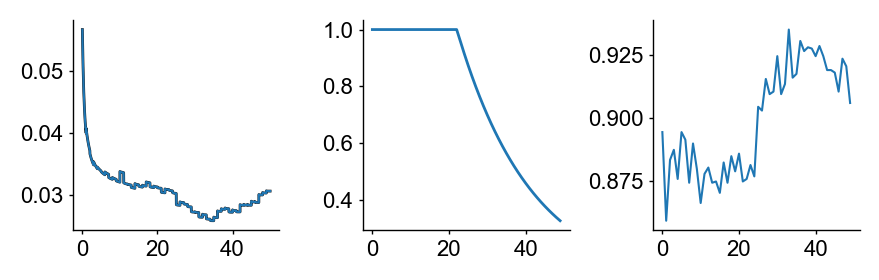

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
ax[0].plot(np.arange(0, n_astep, 1 / n_qstep), np.concatenate(losses), lw = 0.75)
ax[0].plot(np.arange(0, n_astep, 1 / n_qstep), np.concatenate(mu_losses), colors.neutral, zorder = -1)
ax[1].plot(eps_schedule(np.arange(n_astep)))
ax[2].plot(qx_scores, lw = 0.75)
plotter.finalize(fig, None)

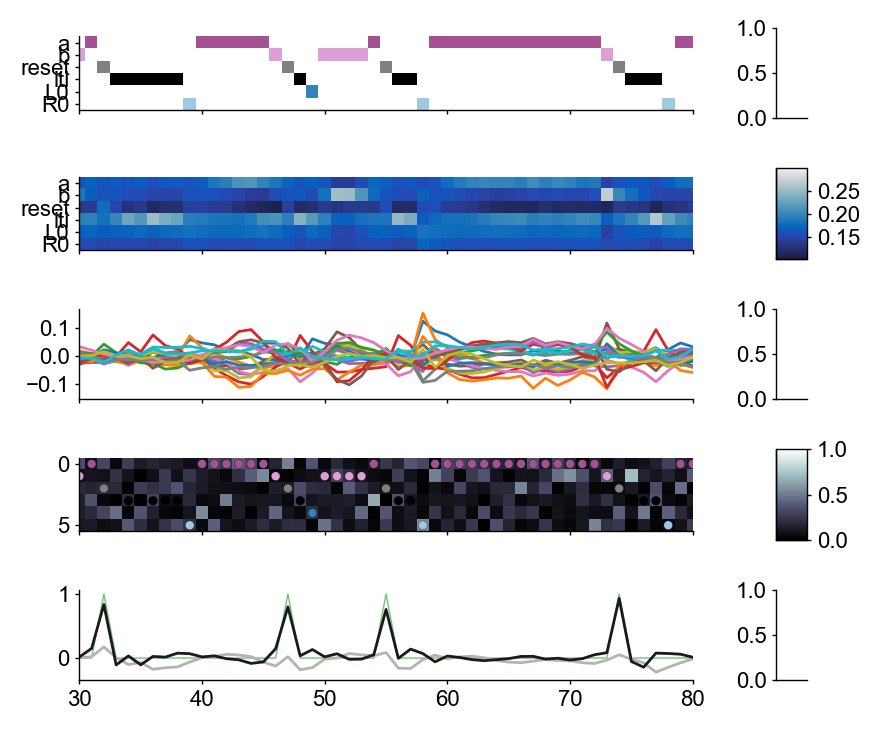

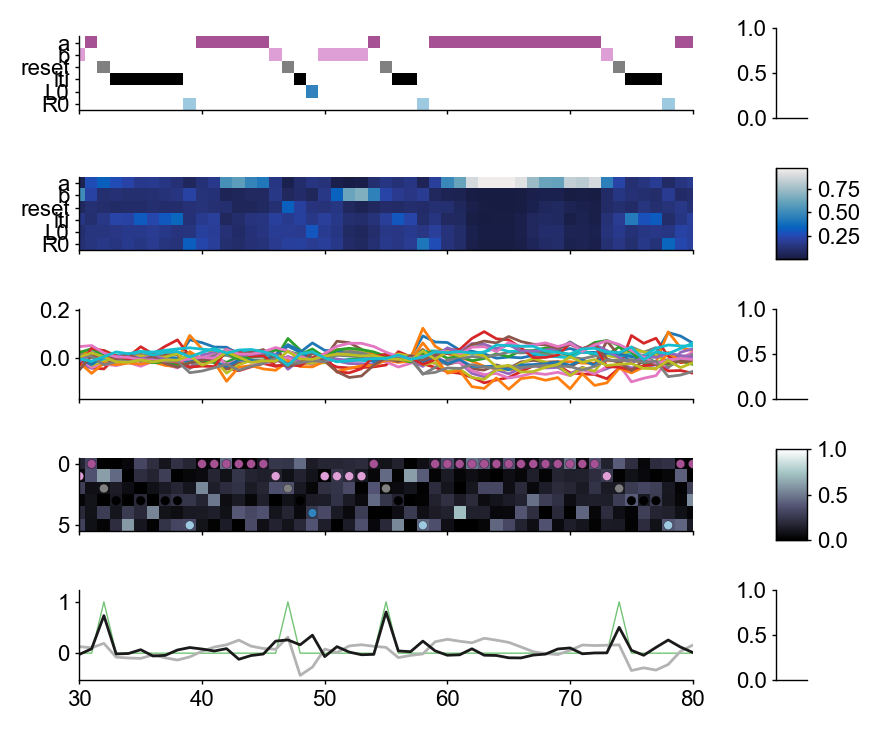

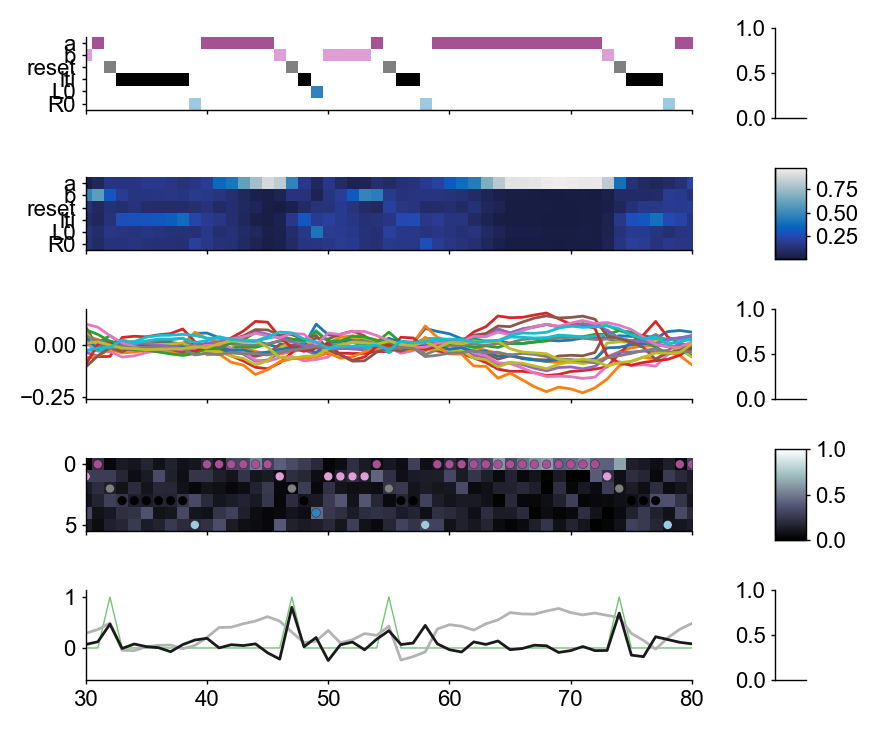

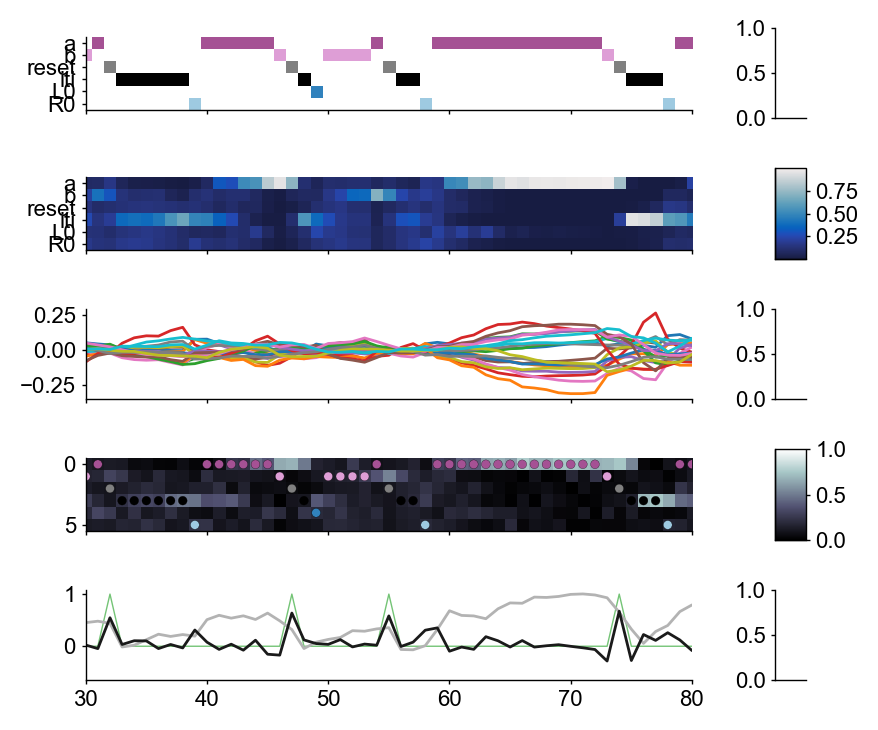

In [45]:
session = 0
for step in np.linspace(0, n_astep - 1, 4).astype(int):
    fig, ax = plt.subplots(5, 2, figsize=(4.5, 3.75), sharex = 'col', width_ratios=[1, 0.05])
    cax = ax[:, 1]
    ax = ax[:, 0]

    cl_ = np.stack([lcolors[l] for l in examples["labels"][session]])[None]
    cl = cl_ * ex_onehots["labels"][session].T[..., None]

    ax[0].imshow(cl, aspect="equal")
    ax[0].set_yticks(range(len(mip["labels"])))
    ax[0].set_yticklabels(mip["labels"])

    _ = ax[1].imshow(
        mu_hist[step][-1][session].T,
        aspect="equal",
        interpolation="nearest",
        cmap=Colormap("cmocean:balance_blue").to_mpl(),
    )
    ax[1].set_yticks(range(len(mip["labels"])))
    ax[1].set_yticklabels(mip["labels"])
    fig.colorbar(_, cax = cax[1])

    ax[2].plot(qx_hist[step][session])

    _ = ax[3].imshow(a_hist[step, session].T, cmap = 'bone', vmin = 0, vmax = 1)
    ax[3].scatter(
        np.arange(sess_len),
        seq_to_ints(examples['labels'][session], mip['labels']),
        c = cl_.squeeze(),
        s = 10,
        linewidths = 0.1,
        edgecolors = 'k')
    fig.colorbar(_, cax = cax[3])

    ax[4].plot(vhat_hists[step][-1][session], color = colors.semisubtle)
    ax[4].plot(rpe_hist[step][-1][session], color = colors.neutral)
    ax[4].plot(r[session], color = t20('c:9'), lw = 0.5, zorder = -1)

    ax[1].set_xlim(30, 80)

    plotter.finalize(fig, None)


In [15]:
vhat_hists[step][-1][session]

(50, 201)